# Physics 404/604

## Computational Physics (Spring 2018)

## BPB-250, Mon./Wed. 2:30-3:45 pm

| Instructor | Prof. Zhaohuan Zhu                 |
| ---------- | :--------------------------------- |
| Email      | zhaohuan.zhu@unlv.edu              |
| Website    | http://www.physics.unlv.edu/~zhzhu |
| Office     | BPB 245                            |





# Fluid Dynamics and Godunov's Method

In this class, we will solve Euler's fluid equation using the Godunov Method

We will start with 1-D problem, trying different Riemann solver and reconstruction method.

## 1-D Godunov's method

We have five variables:

conservative variable (rho, mx1, mx2, mx3, E) or (U[igrid, 0], ..., U[igrid, 4])

primitive variable (rho, vx1, vx2, vx3, pressure) or (W[igrid, 0], ..., W[igrid, 4])

Step 1: initialize the problem

Step 2: compute dt based on CFL condition

Step 3: for each active zone, reconstruct its left and right states

Step 4: for each active zone, use Reimann solver to calculate the flux

Step 5: update quantities using the flux
\begin{equation}
U_{j}^{n+1}=U_{j}^{n}+(F_{j-1/2}-F_{j+1/2})*area/volume*dt
\end{equation}
Note that U have 5 varaibles

Step 6: conversion from conservative to primitive variables. Primitive variables
are useful for timestep and boundary condition calculations

In [1]:
# 1-D Godunov Scheme, simplest possible

import numpy as np
import matplotlib.pylab as p
from mpl_toolkits.mplot3d import Axes3D 

L=100.; Nx=100; NGHOST=2 
tend=21.; vel=1.; Dtout=10.

Nxg=Nx+2*NGHOST  # Total grid number including ghost zones
ist=2           # active zone starting grid number
ien=Nx+2        # active zone ending grid number

NHYDRO=5 # 5 varialbes, rho, mx1, mx2, mx3, E, or rho, vx1, vx2, vx3, pressure
gamma=1.4

dx=L/Nx
darea=1.
dvol=darea*dx

Wsave=np.zeros((Nxg,NHYDRO), float) # save the data for later comparison

def main():

    U=np.zeros((Nxg,NHYDRO), float)  # conserved variable
    W=np.zeros((Nxg,NHYDRO), float)  # primative variable
    Flux=np.zeros((Nxg,NHYDRO), float) 
    fluxa=np.zeros(NHYDRO,float)
    wl=np.zeros(NHYDRO, float)
    wr=np.zeros(NHYDRO, float)

    #Step 1: initialize the problem
    
    for i in range(int((Nxg-1)/2)):
        U[i,0]=8.
        W[i,0]=8.
        W[i,4]=10./gamma
        U[i,4]=W[i,4]/(gamma-1) 
    
    for i in range(int((Nxg-1)/2), Nxg):
        U[i,0]=1.
        W[i,0]=1.
        W[i,4]=1.0/gamma
        U[i,4]=W[i,4]/(gamma-1) 

    toutn=0
    t=0.
    while t < tend:           
        
        #Step 2: calculate dt
        
        dt=0.5*np.min(dx/(np.sqrt(W[ist:ien,1]*W[ist:ien,1]+W[ist:ien,2]*W[ist:ien,2]+W[ist:ien,3]*W[ist:ien,3])+np.sqrt(gamma*W[ist:ien,4]/W[ist:ien,0])))

        for ix in np.arange(ist, ien+1):                       
            # Step 3: reconstruction for left and right state
            reconst_donor(W, wl, wr, ix, dx)       # reconstruction
            # Step 4: Reimann solver to calculate the flux
            rsolver(wl,wr,fluxa, ix)               # Reimann solver
            Flux[ix,:]=fluxa[:]                    # Copy flux
        for ix in np.arange(ist, ien):
            # Step 5: use a conservative form to update the quantities
            for idex in range(NHYDRO):
                # Please finish the next line
                U[ix,idex]=   #update conservative variables
        for ix in np.arange(ist, ien): 
            # Step 6: conversion from conservative to primitive variables
            contoprim(U, W, ix)                    # conservative to primitive variables
        if t >= toutn*Dtout: 
            p.plot(W[:,0])
            print(toutn)   
            toutn += 1                        
        t+=dt
    Wsave[:,:]=W[:,:]
    

def reconst_donor(W, wl, wr, ix, dl): # donor cell reconstruction
    for idex in range(NHYDRO):
        wl[idex]=W[ix-1,idex]
        wr[idex]=W[ix,idex]

def rsolver(wl,wr,fluxa, ix):
    # Compute Roe-averaged state
    sqrtdl = np.sqrt(wl[0])   
    sqrtdr = np.sqrt(wr[0])
    isdlpdr = 1./(sqrtdl+sqrtdr)
    
    roed=sqrtdl*sqrtdr
    roevx=(sqrtdl*wl[1]+sqrtdr*wr[1])*isdlpdr
    roevy=(sqrtdl*wl[2]+sqrtdr*wr[2])*isdlpdr
    roevz=(sqrtdl*wl[3]+sqrtdr*wr[3])*isdlpdr
        #The enthalpy H=(E+P)/d is averaged sqrtdl*hl = sqrtdl*(el+pl)/dl = (el+pl)/sqrtdl
    el = wl[4]/(gamma-1.)+0.5*wl[0]*(wl[1]*wl[1]+wl[2]*wl[2]+wl[3]*wl[3])
    er = wr[4]/(gamma-1.)+0.5*wr[0]*(wr[1]*wr[1]+wr[2]*wr[2]+wr[3]*wr[3])
    roeh = ((el+wl[4])/sqrtdl+(er+wr[4])/sqrtdr)*isdlpdr
    
    # Compute sound speed in L,R, and Roe-averaged state
    cl=np.sqrt(gamma*wl[4]/wl[0])
    cr=np.sqrt(gamma*wr[4]/wr[0])
    q=roeh-0.5*(roevx*roevx+roevy*roevy+roevz*roevz)
    if(q<0.0):
        q=0.0
    a=np.sqrt((gamma-1.)*q)

    # Compute the max/min wave speeds based on L/R and Roe-averaged values
    al=min([roevx-a,wl[1]-cl])
    ar=max([roevx+a,wr[1]+cr])
    if ar>0.0:
        bp=ar
    else:
        bp=0.0
    if al<0.0:
        bm=al
    else:
        bm=0.0
        
    #Compute L/R fluxes along the lines bm/bp: F_L - (S_L)U_L; F_R - (S_R)U_R
    fl=np.zeros(NHYDRO, float)
    fr=np.zeros(NHYDRO, float)
    
    fl[0]=wl[0]*wl[1]-bm*wl[0]
    fr[0]=wr[0]*wr[1]-bp*wr[0]
    fl[1]=wl[0]*wl[1]*(wl[1]-bm)
    fr[1]=wr[0]*wr[1]*(wr[1]-bp)
    fl[2]=wl[0]*wl[2]*(wl[1]-bm)
    fr[2]=wr[0]*wr[2]*(wr[1]-bp)
    fl[3]=wl[0]*wl[3]*(wl[1]-bm)
    fr[3]=wr[0]*wr[3]*(wr[1]-bp)
    fl[1] += wl[4]
    fr[1] += wr[4]
    fl[4] = el*(wl[1]-bm)+wl[4]*wl[1]
    fr[4] = er*(wr[1]-bp)+wr[4]*wr[1]
    
    if (bp==bm):
        tmp = 0.0
    else:
        tmp = 0.5*(bp+bm)/(bp-bm)
        
    fluxa[0]=0.5*(fl[0]+fr[0])+(fl[0]-fr[0])*tmp
    fluxa[1]=0.5*(fl[1]+fr[1])+(fl[1]-fr[1])*tmp
    fluxa[2]=0.5*(fl[2]+fr[2])+(fl[2]-fr[2])*tmp
    fluxa[3]=0.5*(fl[3]+fr[3])+(fl[3]-fr[3])*tmp
    fluxa[4]=0.5*(fl[4]+fr[4])+(fl[4]-fr[4])*tmp
    
def contoprim(U, W, ix):    # conservative variables (mx, my, mz, E) to primative variables (vx, vy, vz, pressure)
    W[ix,0]=U[ix,0]
    W[ix,1]=U[ix,1]/W[ix,0]
    W[ix,2]=U[ix,2]/W[ix,0]
    W[ix,3]=U[ix,3]/W[ix,0]
    W[ix,4]=(U[ix,4]-0.5*W[ix,0]*(W[ix,1]**2+W[ix,2]**2+W[ix,3]**2))*(gamma-1)
    

SyntaxError: invalid syntax (<ipython-input-1-d591f585e799>, line 64)

In [ ]:
main()

In [ ]:
p.show()

In [ ]:
Wdc=Wsave

Using higher order reconstruction will make the code more accurate

In [ ]:
# Please copy above code here, but using the new provided plm reconstruction scheme

def reconst_plm(W, wl, wr, ix, dl):     # second order reconstruction, piece-linear
    for idex in range(NHYDRO):
        dql=(W[ix-1,idex]-W[ix-2,idex])/dl
        dqc=(W[ix,idex]-W[ix-1,idex])/dl
        dqr=(W[ix+1,idex]-W[ix,idex])/dl
        
        dq2=dql*dqc
        if (dq2>0.0):
            if abs(dql)<abs(dqc):
                dqm=dql
            else:
                dqm=dqc
        else:
            dqm=0.0
            
        wl[idex]=W[ix-1,idex]+dqm*dl/2.

        dq2=dqc*dqr
        if(dq2>0.0):
            if abs(dqc)<abs(dqr):
                dqm=dqc
            else:
                dqm=dqr
        else:
            dqm=0.0
        
        wr[idex]=W[ix,idex]-dqm*dl/2.



In [ ]:
main()

In [ ]:
p.show()

In [ ]:
Wpl=Wsave
p.plot(Wdc[:,0])
p.plot(Wpl[:,0])
p.show()

Different Reimann Solver can also affect the solution

In [ ]:
# Please copy the above code but now using the new provided hlle solver

def rsolver_hlle(wl,wr,fluxa, ix):
    # Compute Roe-averaged state
    sqrtdl = np.sqrt(wl[0])   
    sqrtdr = np.sqrt(wr[0])
    isdlpdr = 1./(sqrtdl+sqrtdr)
    
    roed=sqrtdl*sqrtdr
    roevx=(sqrtdl*wl[1]+sqrtdr*wr[1])*isdlpdr
    roevy=(sqrtdl*wl[2]+sqrtdr*wr[2])*isdlpdr
    roevz=(sqrtdl*wl[3]+sqrtdr*wr[3])*isdlpdr
        #The enthalpy H=(E+P)/d is averaged sqrtdl*hl = sqrtdl*(el+pl)/dl = (el+pl)/sqrtdl
    el = wl[4]/(gamma-1.)+0.5*wl[0]*(wl[1]*wl[1]+wl[2]*wl[2]+wl[3]*wl[3])
    er = wr[4]/(gamma-1.)+0.5*wr[0]*(wr[1]*wr[1]+wr[2]*wr[2]+wr[3]*wr[3])
    roeh = ((el+wl[4])/sqrtdl+(er+wr[4])/sqrtdr)*isdlpdr
    
    # Compute sound speed in L,R, and Roe-averaged state
    cl=np.sqrt(gamma*wl[4]/wl[0])
    cr=np.sqrt(gamma*wr[4]/wr[0])
    q=roeh-0.5*(roevx*roevx+roevy*roevy+roevz*roevz)
    if(q<0.0):
        q=0.0
    a=np.sqrt((gamma-1.)*q)

    # Compute the max/min wave speeds based on L/R and Roe-averaged values
    al=min([roevx-a,wl[1]-cl])
    ar=max([roevx+a,wr[1]+cr])
    if ar>0.0:
        bp=ar
    else:
        bp=0.0
    if al<0.0:
        bm=al
    else:
        bm=0.0
        
    #Compute L/R fluxes along the lines bm/bp: F_L - (S_L)U_L; F_R - (S_R)U_R
    fl=np.zeros(NHYDRO, float)
    fr=np.zeros(NHYDRO, float)
    
    fl[0]=wl[0]*wl[1]-bm*wl[0]
    fr[0]=wr[0]*wr[1]-bp*wr[0]
    fl[1]=wl[0]*wl[1]*(wl[1]-bm)
    fr[1]=wr[0]*wr[1]*(wr[1]-bp)
    fl[2]=wl[0]*wl[2]*(wl[1]-bm)
    fr[2]=wr[0]*wr[2]*(wr[1]-bp)
    fl[3]=wl[0]*wl[3]*(wl[1]-bm)
    fr[3]=wr[0]*wr[3]*(wr[1]-bp)
    fl[1] += wl[4]
    fr[1] += wr[4]
    fl[4] = el*(wl[1]-bm)+wl[4]*wl[1]
    fr[4] = er*(wr[1]-bp)+wr[4]*wr[1]
    
    if (bp==bm):
        tmp = 0.0
    else:
        tmp = 0.5*(bp+bm)/(bp-bm)
        
    fluxa[0]=0.5*(fl[0]+fr[0])+(fl[0]-fr[0])*tmp
    fluxa[1]=0.5*(fl[1]+fr[1])+(fl[1]-fr[1])*tmp
    fluxa[2]=0.5*(fl[2]+fr[2])+(fl[2]-fr[2])*tmp
    fluxa[3]=0.5*(fl[3]+fr[3])+(fl[3]-fr[3])*tmp
    fluxa[4]=0.5*(fl[4]+fr[4])+(fl[4]-fr[4])*tmp
    
  

In [ ]:
main()

In [ ]:
p.show()

In [ ]:
p.plot(Wdc[:,0])
p.plot(Wpl[:,0])
p.plot(Wsave[:,0])
p.show()

In [ ]:
# 1-D Godunov Scheme, HLLC solver, linear wave problem

import numpy as np
from vpython import *
import matplotlib.pylab as p
from mpl_toolkits.mplot3d import Axes3D 


scene = canvas() # with this you don't need to restart kernel each time
g   = display(width = 600, height = 300, title = 'Sound wave')


L=100.; Nx=100; NGHOST=2 
tend=300.1; Dtout=10.

Nxg=Nx+2*NGHOST  # Total grid number including ghost zones
ist=2           # active zone starting grid number
ien=Nx+2        # active zone ending grid number

NHYDRO=5 # 5 varialbes, rho, mx1, mx2, mx3, E, or rho, vx1, vx2, vx3, pressure
gamma=1.4

dx=L/Nx
darea=1.
dvol=darea*dx

Wsave=np.zeros((Nxg,NHYDRO), float) # save the data for later comparison

def main():

    U=np.zeros((Nxg,NHYDRO), float)  # conserved variable
    W=np.zeros((Nxg,NHYDRO), float)  # primative variable
    Flux=np.zeros((Nxg,NHYDRO), float) 
    fluxa=np.zeros(NHYDRO,float)
    wl=np.zeros(NHYDRO, float)
    wr=np.zeros(NHYDRO, float)
# Step 1: initialize the wave solution
    for i in range(Nxg):
        W[i,0]=1.+0.1*np.cos((i+0.5)*dx/L*2.*np.pi)
        W[i,1]=-0.1*np.sqrt(gamma)*np.cos((i+0.5)*dx/L*2.*np.pi)
        W[i,4]=1.+0.1*np.cos((i+0.5)*dx/L*2.*np.pi)*gamma
        U[i,0]=W[i,0]
        U[i,1]=W[i,0]*W[i,1]
        U[i,4]=W[i,4]/(gamma-1)+0.5*W[i,0]*W[i,1]*W[i,1]


    toutn=0
    t=0.
    while t < tend:           
        dt=0.4*np.min(dx/(np.sqrt(W[ist:ien,1]*W[ist:ien,1]+W[ist:ien,2]*W[ist:ien,2]+W[ist:ien,3]*W[ist:ien,3])+np.sqrt(gamma*W[ist:ien,4]/W[ist:ien,0])))
        for ix in np.arange(ist, ien+1):                       
            reconst_donor(W, wl, wr, ix, dx)
#            reconst_plm1(W, wl, wr, ix, dx)         # reconstruction
            rsolver(wl,wr,fluxa, ix)               # Reimann solver
            Flux[ix,:]=fluxa[:]
        for ix in np.arange(ist, ien): 
            for idex in range(NHYDRO):
                U[ix,idex]=U[ix,idex]-(Flux[ix+1,idex]-Flux[ix,idex])*dt*darea/dvol    # update conservative variables
        for ix in np.arange(ist, ien): 
            contoprim(U, W, ix)
# boundary condition
        # Please implement the periodic boundary condition
            
        if t >= toutn*Dtout: 
            p.plot(W[:,0])
            print(toutn)   
            toutn += 1                        
        t+=dt
        
        sol = curve(pos=[vector(2,(W[2,0]-1.)*100., 0), vector(3,(W[3,0]-1.)*100.,0)], color = color.yellow)
                        # Plot every other point
        for i in range(4, Nxg-2): 
            sol.append(vector(i,(W[i,0]-1.)*100.,0))
            
        rate(100)
        for obj in scene.objects:
            obj.visible=0 

    Wsave[:,:]=W[:,:]
    

def reconst_donor(W, wl, wr, ix, dl):
    for idex in range(NHYDRO):
        wl[idex]=W[ix-1,idex]
        wr[idex]=W[ix,idex]
    
def reconst_plm1(W, wl, wr, ix, dl):     # second order reconstruction, piece-linear
    for idex in range(NHYDRO):
        dql=(W[ix-1,idex]-W[ix-2,idex])/dl
        dqc=(W[ix,idex]-W[ix-1,idex])/dl
        dqr=(W[ix+1,idex]-W[ix,idex])/dl
        
        dq2=dql*dqc
        if (dq2>0.0):
            dqm=dq2/(dql+dqc)
        else:
            dqm=0.0
            
        wl[idex]=W[ix-1,idex]+dqm*dl

        dq2=dqc*dqr
        if(dq2>0.0):
            dqm=dq2/(dqc+dqr)
        else:
            dqm=0.0
        
        wr[idex]=W[ix,idex]-dqm*dl
    
def rsolver(wl,wr,fluxa, ix):
    rsolver_hllc(wl,wr,fluxa, ix)
    
def rsolver_hllc(wl,wr,fluxa, ix):
    # Compute Roe-averaged state
    sqrtdl = np.sqrt(wl[0])   
    sqrtdr = np.sqrt(wr[0])
    isdlpdr = 1./(sqrtdl+sqrtdr)
    
    roed=sqrtdl*sqrtdr
    roevx=(sqrtdl*wl[1]+sqrtdr*wr[1])*isdlpdr
    roevy=(sqrtdl*wl[2]+sqrtdr*wr[2])*isdlpdr
    roevz=(sqrtdl*wl[3]+sqrtdr*wr[3])*isdlpdr
        #The enthalpy H=(E+P)/d is averaged sqrtdl*hl = sqrtdl*(el+pl)/dl = (el+pl)/sqrtdl
    el = wl[4]/(gamma-1.)+0.5*wl[0]*(wl[1]*wl[1]+wl[2]*wl[2]+wl[3]*wl[3])
    er = wr[4]/(gamma-1.)+0.5*wr[0]*(wr[1]*wr[1]+wr[2]*wr[2]+wr[3]*wr[3])
    roeh = ((el+wl[4])/sqrtdl+(er+wr[4])/sqrtdr)*isdlpdr
    
    # Compute sound speed in L,R, and Roe-averaged state
    cl=np.sqrt(gamma*wl[4]/wl[0])
    cr=np.sqrt(gamma*wr[4]/wr[0])
    q=roeh-0.5*(roevx*roevx+roevy*roevy+roevz*roevz)
    if(q<0.0):
        q=0.0
    a=np.sqrt((gamma-1.)*q)

    # Compute the max/min wave speeds based on L/R and Roe-averaged values
    al=min([roevx-a,wl[1]-cl])
    ar=max([roevx+a,wr[1]+cr])
    if ar>0.0:
        bp=ar
    else:
        bp=0.0
    if al<0.0:
        bm=al
    else:
        bm=0.0
    
    #compute the contact wave speed and pressure
    vxl = wl[1]-al
    vxr = wr[1]-ar
    tl=wl[4] + vxl*wl[0]*wl[1]
    tr=wr[4] + vxr*wr[0]*wr[1]
        
    ml = wl[0]*vxl
    mr = -wr[0]*vxr
        # determine the contact wave spped
    am = (tl-tr)/(ml+mr)
        # determine the pressure at the contact surface
    cp = (ml*tr+mr*tl)/(ml+mr)
    cp = max([cp,0.0])
        
    #Compute L/R fluxes along the lines bm/bp: F_L - (S_L)U_L; F_R - (S_R)U_R
    fl=np.zeros(NHYDRO, float)
    fr=np.zeros(NHYDRO, float)
    
    fl[0]=wl[0]*wl[1]-bm*wl[0]
    fr[0]=wr[0]*wr[1]-bp*wr[0]
    fl[1]=wl[0]*wl[1]*(wl[1]-bm)
    fr[1]=wr[0]*wr[1]*(wr[1]-bp)
    fl[2]=wl[0]*wl[2]*(wl[1]-bm)
    fr[2]=wr[0]*wr[2]*(wr[1]-bp)
    fl[3]=wl[0]*wl[3]*(wl[1]-bm)
    fr[3]=wr[0]*wr[3]*(wr[1]-bp)
    fl[1] += wl[4]
    fr[1] += wr[4]
    fl[4] = el*(wl[1]-bm)+wl[4]*wl[1]
    fr[4] = er*(wr[1]-bp)+wr[4]*wr[1]
    
    # compute flux weights or scales
    
    if (am>=0.0):
        sl = am/(am-bm)
        sr = 0.0
        sm = -bm/(am-bm)
    else:
        sl = 0.0
        sr = -am/(bp-am)
        sm = bp/(bp-am)
        
    # compute flux at the interface , including the weighted contribution from the contact
    fluxa[0]=sl*fl[0] + sr*fr[0]
    fluxa[1]=sl*fl[1] + sr*fr[1]+sm*cp
    fluxa[2]=sl*fl[2] + sr*fr[2]
    fluxa[3]=sl*fl[3] + sr*fr[3]
    fluxa[4]=sl*fl[4] + sr*fr[4] + sm*cp*am
        
def contoprim(U, W, ix):     # conservative variables (mx, my, mz, E) to primative variables (vx, vy, vz, pressure)
    W[ix,0]=U[ix,0]
    W[ix,1]=U[ix,1]/W[ix,0]
    W[ix,2]=U[ix,2]/W[ix,0]
    W[ix,3]=U[ix,3]/W[ix,0]
    W[ix,4]=(U[ix,4]-0.5*W[ix,0]*(W[ix,1]**2+W[ix,2]**2+W[ix,3]**2))*(gamma-1)
    

In [ ]:
main()

In [ ]:
p.show()

In [ ]:
p.plot(Wsave[:,0])
p.show()

To increase the time stepping accuracy to be second-order accurate in time, use predict-correct scheme.

Predict middle point quantities and then use them to calculate the final quantitites.

In [ ]:
# 1-D Godunov Scheme, HLLC solver, linear wave problem, Predict-correct scheme

import numpy as np
from vpython import *
import matplotlib.pylab as p
from mpl_toolkits.mplot3d import Axes3D 


scene = canvas() # with this you don't need to restart kernel each time
g   = display(width = 600, height = 300, title = 'Sound wave')


L=100.; Nx=100; NGHOST=2 
tend=300.1; Dtout=10.

Nxg=Nx+2*NGHOST  # Total grid number including ghost zones
ist=2           # active zone starting grid number
ien=Nx+2        # active zone ending grid number

NHYDRO=5 # 5 varialbes, rho, mx1, mx2, mx3, E, or rho, vx1, vx2, vx3, pressure
gamma=1.4

dx=L/Nx
darea=1.
dvol=darea*dx

Wsave=np.zeros((Nxg,NHYDRO), float) # save the data for later comparison

def main():

    U=np.zeros((Nxg,NHYDRO), float)  # conserved variable
    W=np.zeros((Nxg,NHYDRO), float)  # primative variable
    Um=np.zeros((Nxg,NHYDRO), float)  # conserved variable middle point
    Wm=np.zeros((Nxg,NHYDRO), float)  # primative variable middle point
    Flux=np.zeros((Nxg,NHYDRO), float) 
    fluxa=np.zeros(NHYDRO,float)
    wl=np.zeros(NHYDRO, float)
    wr=np.zeros(NHYDRO, float)

    for i in range(Nxg):
        W[i,0]=1.+0.1*np.cos((i+0.5)*dx/L*2.*np.pi)
        W[i,1]=-0.1*np.sqrt(gamma)*np.cos((i+0.5)*dx/L*2.*np.pi)
        W[i,4]=1.+0.1*np.cos((i+0.5)*dx/L*2.*np.pi)*gamma
        U[i,0]=W[i,0]
        U[i,1]=W[i,0]*W[i,1]
        U[i,4]=W[i,4]/(gamma-1)+0.5*W[i,0]*W[i,1]*W[i,1]


    toutn=0
    t=0.
    while t < tend:           
        dt=0.4*np.min(dx/(np.sqrt(W[ist:ien,1]*W[ist:ien,1]+W[ist:ien,2]*W[ist:ien,2]+W[ist:ien,3]*W[ist:ien,3])+np.sqrt(gamma*W[ist:ien,4]/W[ist:ien,0])))
        for ix in np.arange(ist, ien+1):                       
#            reconst_donor(W, wl, wr, ix, dx)
            reconst_plm1(W, wl, wr, ix, dx)         # reconstruction
            rsolver(wl,wr,fluxa, ix)               # Reimann solver
            Flux[ix,:]=fluxa[:]
        for ix in np.arange(ist, ien): 
            for idex in range(NHYDRO):
                # update the middle point quantities, using 0.5*dt
                Um[ix,idex]=U[ix,idex]-(Flux[ix+1,idex]-Flux[ix,idex])*0.5*dt*darea/dvol    # update conservative variables
        for ix in np.arange(ist, ien): 
            contoprim(Um, Wm, ix)
# boundary condition
        Wm[0,:]=Wm[Nxg-4,:]
        Wm[1,:]=Wm[Nxg-3,:]
        Wm[Nxg-2,:]=Wm[2,:]
        Wm[Nxg-1,:]=Wm[3,:]
            
        for ix in np.arange(ist, ien+1):                       
#            reconst_donor(W, wl, wr, ix, dx)
            reconst_plm1(Wm, wl, wr, ix, dx)         # reconstruction
            rsolver(wl,wr,fluxa, ix)               # Reimann solver
            Flux[ix,:]=fluxa[:]
        for ix in np.arange(ist, ien): 
            for idex in range(NHYDRO):
                # Update the final quantities
                U[ix,idex]=U[ix,idex]-(Flux[ix+1,idex]-Flux[ix,idex])*dt*darea/dvol    # update conservative variables
        for ix in np.arange(ist, ien): 
            contoprim(U, W, ix)
# boundary condition
        W[0,:]=W[Nxg-4,:]
        W[1,:]=W[Nxg-3,:]
        W[Nxg-2,:]=W[2,:]
        W[Nxg-1,:]=W[3,:]
            
        if t >= toutn*Dtout: 
            p.plot(W[:,0])
            print(toutn)   
            toutn += 1                        
        t+=dt
        
        sol = curve(pos=[vector(2,(W[2,0]-1.)*100., 0), vector(3,(W[3,0]-1.)*100.,0)], color = color.yellow)
                        # Plot every other point
        for i in range(4, Nxg-2): 
            sol.append(vector(i,(W[i,0]-1.)*100.,0))
            
        rate(100)
        for obj in scene.objects:
            obj.visible=0 

    Wsave[:,:]=W[:,:]
    

def reconst_donor(W, wl, wr, ix, dl):
    for idex in range(NHYDRO):
        wl[idex]=W[ix-1,idex]
        wr[idex]=W[ix,idex]
    
def reconst_plm1(W, wl, wr, ix, dl):     # second order reconstruction, piece-linear
    for idex in range(NHYDRO):
        dql=(W[ix-1,idex]-W[ix-2,idex])/dl
        dqc=(W[ix,idex]-W[ix-1,idex])/dl
        dqr=(W[ix+1,idex]-W[ix,idex])/dl
        
        dq2=dql*dqc
        if (dq2>0.0):
            dqm=dq2/(dql+dqc)
        else:
            dqm=0.0
            
        wl[idex]=W[ix-1,idex]+dqm*dl

        dq2=dqc*dqr
        if(dq2>0.0):
            dqm=dq2/(dqc+dqr)
        else:
            dqm=0.0
        
        wr[idex]=W[ix,idex]-dqm*dl
        

def rsolver(wl,wr,fluxa, ix):
    rsolver_hllc(wl,wr,fluxa, ix)
    
    
def rsolver_hllc(wl,wr,fluxa, ix):
    # Compute Roe-averaged state
    sqrtdl = np.sqrt(wl[0])   
    sqrtdr = np.sqrt(wr[0])
    isdlpdr = 1./(sqrtdl+sqrtdr)
    
    roed=sqrtdl*sqrtdr
    roevx=(sqrtdl*wl[1]+sqrtdr*wr[1])*isdlpdr
    roevy=(sqrtdl*wl[2]+sqrtdr*wr[2])*isdlpdr
    roevz=(sqrtdl*wl[3]+sqrtdr*wr[3])*isdlpdr
        #The enthalpy H=(E+P)/d is averaged sqrtdl*hl = sqrtdl*(el+pl)/dl = (el+pl)/sqrtdl
    el = wl[4]/(gamma-1.)+0.5*wl[0]*(wl[1]*wl[1]+wl[2]*wl[2]+wl[3]*wl[3])
    er = wr[4]/(gamma-1.)+0.5*wr[0]*(wr[1]*wr[1]+wr[2]*wr[2]+wr[3]*wr[3])
    roeh = ((el+wl[4])/sqrtdl+(er+wr[4])/sqrtdr)*isdlpdr
    
    # Compute sound speed in L,R, and Roe-averaged state
    cl=np.sqrt(gamma*wl[4]/wl[0])
    cr=np.sqrt(gamma*wr[4]/wr[0])
    q=roeh-0.5*(roevx*roevx+roevy*roevy+roevz*roevz)
    if(q<0.0):
        q=0.0
    a=np.sqrt((gamma-1.)*q)

    # Compute the max/min wave speeds based on L/R and Roe-averaged values
    al=min([roevx-a,wl[1]-cl])
    ar=max([roevx+a,wr[1]+cr])
    if ar>0.0:
        bp=ar
    else:
        bp=0.0
    if al<0.0:
        bm=al
    else:
        bm=0.0
    
    #compute the contact wave speed and pressure
    vxl = wl[1]-al
    vxr = wr[1]-ar
    tl=wl[4] + vxl*wl[0]*wl[1]
    tr=wr[4] + vxr*wr[0]*wr[1]
        
    ml = wl[0]*vxl
    mr = -wr[0]*vxr
        # determine the contact wave spped
    am = (tl-tr)/(ml+mr)
        # determine the pressure at the contact surface
    cp = (ml*tr+mr*tl)/(ml+mr)
    cp = max([cp,0.0])
        
    #Compute L/R fluxes along the lines bm/bp: F_L - (S_L)U_L; F_R - (S_R)U_R
    fl=np.zeros(NHYDRO, float)
    fr=np.zeros(NHYDRO, float)
    
    fl[0]=wl[0]*wl[1]-bm*wl[0]
    fr[0]=wr[0]*wr[1]-bp*wr[0]
    fl[1]=wl[0]*wl[1]*(wl[1]-bm)
    fr[1]=wr[0]*wr[1]*(wr[1]-bp)
    fl[2]=wl[0]*wl[2]*(wl[1]-bm)
    fr[2]=wr[0]*wr[2]*(wr[1]-bp)
    fl[3]=wl[0]*wl[3]*(wl[1]-bm)
    fr[3]=wr[0]*wr[3]*(wr[1]-bp)
    fl[1] += wl[4]
    fr[1] += wr[4]
    fl[4] = el*(wl[1]-bm)+wl[4]*wl[1]
    fr[4] = er*(wr[1]-bp)+wr[4]*wr[1]
    
    # compute flux weights or scales
    
    if (am>=0.0):
        sl = am/(am-bm)
        sr = 0.0
        sm = -bm/(am-bm)
    else:
        sl = 0.0
        sr = -am/(bp-am)
        sm = bp/(bp-am)
        
    # compute flux at the interface , including the weighted contribution from the contact
    fluxa[0]=sl*fl[0] + sr*fr[0]
    fluxa[1]=sl*fl[1] + sr*fr[1]+sm*cp
    fluxa[2]=sl*fl[2] + sr*fr[2]
    fluxa[3]=sl*fl[3] + sr*fr[3]
    fluxa[4]=sl*fl[4] + sr*fr[4] + sm*cp*am
        
def contoprim(U, W, ix):     # conservative variables (mx, my, mz, E) to primative variables (vx, vy, vz, pressure)
    W[ix,0]=U[ix,0]
    W[ix,1]=U[ix,1]/W[ix,0]
    W[ix,2]=U[ix,2]/W[ix,0]
    W[ix,3]=U[ix,3]/W[ix,0]
    W[ix,4]=(U[ix,4]-0.5*W[ix,0]*(W[ix,1]**2+W[ix,2]**2+W[ix,3]**2))*(gamma-1)
    

In [ ]:
main()

## 2-D Godunov's method


Step 1: initialize the problem

Step 2: compute dt based on CFL condition

Step 3: in the x-direction (or x-sweep), for each active zone, reconstruct its left and right states

Step 4: in the x-direction (or x-sweep), for each active zone, use Reimann solver to calculate the flux

Step 5: do Step 3 and 4 for the y-direction.

Step 6: update quantities using the flux
\begin{equation}
U_{i,j}^{n+1}=U_{i,j}^{n}+(Fx_{i-1/2,j}-Fx_{i+1/2,j})*area_y/volume*dt+(Fy_{i,j-1/2}-Fx_{i,j+1/2})*area_x/volume*dt
\end{equation}
Note that U have 5 varaibles

Step 7: conversion from conservative to primitive variables. Primitive variables
are useful for timestep and boundary condition calculations

In [5]:
# 2-D Godunov scheme

import numpy as np
import matplotlib.pylab as p
from mpl_toolkits.mplot3d import Axes3D 

L=100.; Nx=100; NGHOST=2; Ny=100
tend=10.1; Dtout=1.

Nxg=Nx+2*NGHOST  # Total grid number including ghost zones
Nyg=Ny+2*NGHOST

ist=2           # i direction: active zone starting grid number
ien=Nx+2        # i direction: active zone ending grid number
jst=2           # j direction: active zone starting grid number
jen=Ny+2

NHYDRO=5 # 5 varialbes, rho, mx1, mx2, mx3, E, or rho, vx1, vx2, vx3, pressure
gamma=1.4

dx=L/Nx
dy=L/Ny
dareax=dy       # area perpendicular to the x direction
dareay=dx       # area perpendicular to the y direction
dvol=dy*dx      # volume of each grid

Wsave=np.zeros((Nyg,Nxg,int(tend/Dtout)+1,NHYDRO), float)

def main():

    U=np.zeros((Nyg,Nxg,NHYDRO), float)  # conserved variable
    W=np.zeros((Nyg,Nxg,NHYDRO), float)  # primative variable
    Um=np.zeros((Nyg,Nxg,NHYDRO), float)  # conserved variable at mid point
    Wm=np.zeros((Nyg,Nxg,NHYDRO), float)  # primative variable at mid point
    Fluxx=np.zeros((Nyg,Nxg,NHYDRO), float)  # flux from the x-direction interface
    Fluxy=np.zeros((Nyg,Nxg,NHYDRO), float)  # flux from the y-direction interface
    fluxa=np.zeros(NHYDRO,float)             # temperal flux for the single interface
    wl=np.zeros(NHYDRO, float)          # left state
    wr=np.zeros(NHYDRO, float)          # right state

    # setup the problem
    prob2(U,W)
    Um[:]=U[:]
    Wm[:]=W[:]

    toutn=0
    t=0.
    while t < tend:   
        # time step
        dt=0.5*np.min(np.min([dx,dy])/(np.sqrt(W[jst:jen,ist:ien,1]*W[jst:jen,ist:ien,1]+W[jst:jen,ist:ien,2]*W[jst:jen,ist:ien,2]+W[jst:jen,ist:ien,3]*W[jst:jen,ist:ien,3])+np.sqrt(gamma*W[jst:jen,ist:ien,4]/W[jst:jen,ist:ien,0])))
        # calculate x interface flux
        for j in np.arange(jst, jen+1):
            for i in np.arange(ist, ien+1):                       
                reconst(W, wl, wr, i, j, dx, dy, 1)    
                rsolver(wl,wr,fluxa,1)
                Fluxx[j,i,:]=fluxa[:]
        # calculate y interface flux
        for i in np.arange(ist, ien+1):
            for j in np.arange(jst, jen+1):
                reconst(W, wl, wr, i, j, dx, dy, 2)
                rsolver(wl,wr,fluxa,2)
                Fluxy[j,i,:]=fluxa[:]
        # update all the active zone
        for j in np.arange(jst,jen):
            for i in np.arange(ist, ien): 
                for idex in range(NHYDRO):
                    Um[j,i,idex]=U[j,i,idex] + (Fluxx[j,i,idex]-Fluxx[j,i+1,idex])*0.5*dt*dareax/dvol + (Fluxy[j,i,idex]-Fluxy[j+1,i,idex])*0.5*dt*dareay/dvol# finish this line to update quantities in a grid
        # conservative varialbe to primitive variable
        contoprim(Um, Wm)
        # update the primitive variable at the boundary
        boundary(W)

                
        if t >= toutn*Dtout: 
            print(toutn)   
            x = list(range(0, Nxg))                       # Plot alternate pts
            y = list(range(0, Nyg))                      
            X, Y = p.meshgrid(x, y)                       
            Z = W[Y,X,0]                                  # plot 0: density,...
            levels=p.arange(np.min(Z)*0.8,np.max(Z)*1.2,(np.max(Z)*1.2 - np.min(Z)*0.8)/256.)
            CS=p.contour(x,y,Z,levels)
            p.xlabel('X')
            p.ylabel('Y')
            p.colorbar(CS)
            p.show()  
            toutn += 1    
            
            
        t+=dt
        print(dt)
    
        

                                 
    print("finished") 

    

# Sod shock tube in the x direction    
def prob1(U,W):
    for j in range(Nyg):
        for i in range(int(Nxg/2)):
            U[j,i,0]=8.
            W[j,i,0]=8.
            W[j,i,4]=10./gamma
            U[j,i,4]=W[j,i,4]/(gamma-1) 
        for i in range(int(Nxg/2), Nxg):
            U[j,i,0]=1.
            W[j,i,0]=1.
            W[j,i,4]=1.0/gamma
            U[j,i,4]=W[j,i,4]/(gamma-1) 
    boundary(W)

# blast wave solution  
def prob2(U,W):
    for j in range(Nyg):
        for i in range(Nxg):
            if (i-Nxg/2.)*(i-Nxg/2)+(j-Nyg/2.)*(j-Nyg/2)<100.0:
                U[j,i,0]=1.
                W[j,i,0]=1.
                W[j,i,4]=1.0/gamma
                U[j,i,4]=W[j,i,4]/(gamma-1) 
            else:
                U[j,i,0]=0.1
                W[j,i,0]=0.1
                W[j,i,4]=0.1/gamma
                U[j,i,4]=W[j,i,4]/(gamma-1) 
    boundary(W)


    
# reconstruction
def reconst(W, wl, wr, i, j, dlx, dly, dire):
    reconst_plm(W, wl, wr, i, j, dlx, dly, dire)
    
# donor cell reconstruction
def reconst_donor(W, wl, wr, i, j, dlx, dly, dire):
    if dire==1:
        for idex in range(NHYDRO):
            wl[idex]=W[j,i-1,idex]
            wr[idex]=W[j,i,idex]
    if dire==2:
        for idex in range(NHYDRO):
            wl[idex]=W[j-1,i,idex]
            wr[idex]=W[j,i,idex]
            
        
# piecewise linear reconstruction
def reconst_plm(W, wl, wr, i, j, dlx, dly, dire):
    for idex in range(NHYDRO):
        if dire==1:
            wm1=W[j,i-1,idex]
            wm2=W[j,i-2,idex]
            w=W[j,i,idex]
            wp1=W[j,i+1,idex]
            dl=dlx
        if dire==2:
            wm1=W[j-1,i,idex]
            wm2=W[j-2,i,idex]
            w=W[j,i,idex]
            wp1=W[j+1,i,idex]
            dl=dly
        dql=(wm1-wm2)/dl
        dqc=(w-wm1)/dl
        dqr=(wp1-w)/dl
        
        dq2=dql*dqc
        if (dq2>0.0):
            dqm=dq2/(dql+dqc)
        else:
            dqm=0.0
            
        wl[idex]=wm1+dqm*dl

        dq2=dqc*dqr
        if(dq2>0.0):
            dqm=dq2/(dqc+dqr)
        else:
            dqm=0.0
        
        wr[idex]=w-dqm*dl

# hlle Reimann solver
def rsolver(wl,wr,fluxa,dire):
    # Compute Roe-averaged state
    if dire==1:
        ivx=1
        ivy=2
    if dire==2:
        ivx=2
        ivy=1
    sqrtdl = np.sqrt(wl[0])   
    sqrtdr = np.sqrt(wr[0])
    isdlpdr = 1./(sqrtdl+sqrtdr)
    
    roed=sqrtdl*sqrtdr
    roevx=(sqrtdl*wl[ivx]+sqrtdr*wr[ivx])*isdlpdr
    roevy=(sqrtdl*wl[ivy]+sqrtdr*wr[ivy])*isdlpdr
    roevz=(sqrtdl*wl[3]+sqrtdr*wr[3])*isdlpdr
        #The enthalpy H=(E+P)/d is averaged sqrtdl*hl = sqrtdl*(el+pl)/dl = (el+pl)/sqrtdl
    el = wl[4]/(gamma-1.)+0.5*wl[0]*(wl[ivx]*wl[ivx]+wl[ivy]*wl[ivy]+wl[3]*wl[3])
    er = wr[4]/(gamma-1.)+0.5*wr[0]*(wr[ivx]*wr[ivx]+wr[ivy]*wr[ivy]+wr[3]*wr[3])
    roeh = ((el+wl[4])/sqrtdl+(er+wr[4])/sqrtdr)*isdlpdr
    
    # Compute sound speed in L,R, and Roe-averaged state
    cl=np.sqrt(gamma*wl[4]/wl[0])
    cr=np.sqrt(gamma*wr[4]/wr[0])
    q=roeh-0.5*(roevx*roevx+roevy*roevy+roevz*roevz)
    if(q<0.0):
        q=0.0
    a=np.sqrt((gamma-1.)*q)

    # Compute the max/min wave speeds based on L/R and Roe-averaged values
    al=min([roevx-a,wl[ivx]-cl])
    ar=max([roevx+a,wr[ivx]+cr])
    if ar>0.0:
        bp=ar
    else:
        bp=0.0
    if al<0.0:
        bm=al
    else:
        bm=0.0
        
    #Compute L/R fluxes along the lines bm/bp: F_L - (S_L)U_L; F_R - (S_R)U_R
    fl=np.zeros(NHYDRO, float)
    fr=np.zeros(NHYDRO, float)
    
    fl[0]=wl[0]*wl[ivx]-bm*wl[0]
    fr[0]=wr[0]*wr[ivx]-bp*wr[0]
    fl[ivx]=wl[0]*wl[ivx]*(wl[ivx]-bm)
    fr[ivx]=wr[0]*wr[ivx]*(wr[ivx]-bp)
    fl[ivy]=wl[0]*wl[ivy]*(wl[ivx]-bm)
    fr[ivy]=wr[0]*wr[ivy]*(wr[ivx]-bp)
    fl[3]=wl[0]*wl[3]*(wl[ivx]-bm)
    fr[3]=wr[0]*wr[3]*(wr[ivx]-bp)
    fl[ivx] += wl[4]
    fr[ivx] += wr[4]
    fl[4] = el*(wl[ivx]-bm)+wl[4]*wl[ivx]
    fr[4] = er*(wr[ivx]-bp)+wr[4]*wr[ivx]
    
    if (bp==bm):
        tmp = 0.0
    else:
        tmp = 0.5*(bp+bm)/(bp-bm)
        
    fluxa[0]=0.5*(fl[0]+fr[0])+(fl[0]-fr[0])*tmp
    fluxa[ivx]=0.5*(fl[ivx]+fr[ivx])+(fl[ivx]-fr[ivx])*tmp
    fluxa[ivy]=0.5*(fl[ivy]+fr[ivy])+(fl[ivy]-fr[ivy])*tmp
    fluxa[3]=0.5*(fl[3]+fr[3])+(fl[3]-fr[3])*tmp
    fluxa[4]=0.5*(fl[4]+fr[4])+(fl[4]-fr[4])*tmp
    
# conservative variables to primitive variables
def contoprim(U, W):
    for j in np.arange(jst,jen):
            for i in np.arange(ist, ien):
                W[j,i,0]=max([U[j,i,0],1.e-30]) # to add stability for the Reimann solver, make sure density and pressure are positive
                W[j,i,1]=U[j,i,1]/W[j,i,0]
                W[j,i,2]=U[j,i,2]/W[j,i,0]
                W[j,i,3]=U[j,i,3]/W[j,i,0]
                W[j,i,4]=max([(U[j,i,4]-0.5*W[j,i,0]*(W[j,i,1]**2+W[j,i,2]**2+W[j,i,3]**2))*(gamma-1),1.e-30])
    
# primitive variables to conservative variables   
def primtocon(W,U):
    for j in np.arange(jst,jen):
            for i in np.arange(ist, ien):
                U[j,i,0]=W[j,i,0]
                U[j,i,1]=W[j,i,1]*W[j,i,0]
                U[j,i,2]=W[j,i,2]*W[j,i,0]
                U[j,i,3]=W[j,i,3]*W[j,i,0]
                U[j,i,4]=0.5*W[j,i,0]*(W[j,i,1]**2+W[j,i,2]**2+W[j,i,3]**2)+W[j,i,4]/(gamma-1)

# boundary condition
def boundary(W):    
    periodic(W)
    
# periodic boundary
def periodic(W):
    for j in np.arange(jst,jen):
        for idex in range(NHYDRO):
            W[j,0,idex]=W[j,Nxg-4,idex]
            W[j,1,idex]=W[j,Nxg-3,idex]
            W[j,Nxg-2,idex]=W[j,2,idex]
            W[j,Nxg-1,idex]=W[j,3,idex]
                
    for i in np.arange(0,Nxg):
        for idex in range(NHYDRO):
            W[0,i,idex]=W[Nyg-4,i,idex]
            W[1,i,idex]=W[Nyg-3,i,idex]
            W[Nyg-2,i,idex]=W[2,i,idex]
            W[Nyg-1,i,idex]=W[3,i,idex]
    
# outflow boundary
def outflow(W):
    for j in np.arange(jst,jen):
        for idex in range(NHYDRO):
            W[j,0,idex]=W[j,2,idex]
            W[j,1,idex]=W[j,2,idex]
            W[j,Nxg-2,idex]=W[j,Nxg-3,idex]
            W[j,Nxg-1,idex]=W[j,Nxg-3,idex]
                
    for i in np.arange(0,Nxg):
        for idex in range(NHYDRO):
            W[0,i,idex]=W[2,i,idex]
            W[1,i,idex]=W[2,i,idex]
            W[Nyg-2,i,idex]=W[Nyg-3,i,idex]
            W[Nyg-1,i,idex]=W[Nyg-3,i,idex]

0


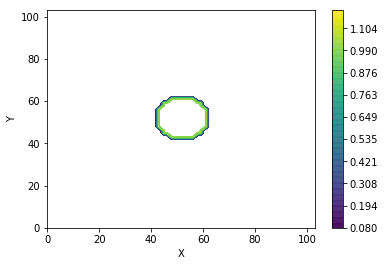

0.5
0.5
1


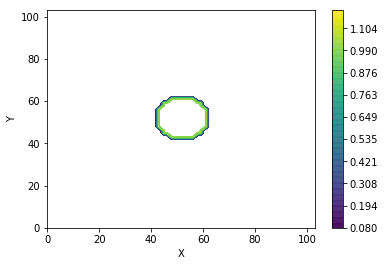

0.5
0.5
2


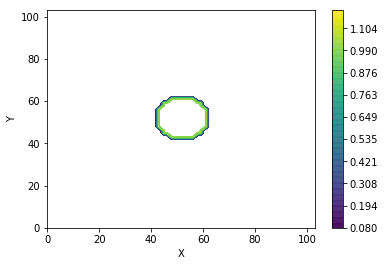

0.5
0.5
3


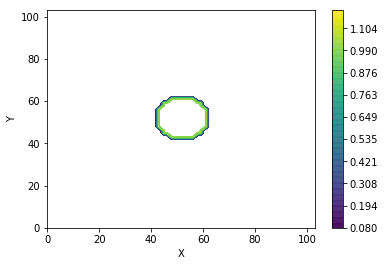

0.5
0.5
4


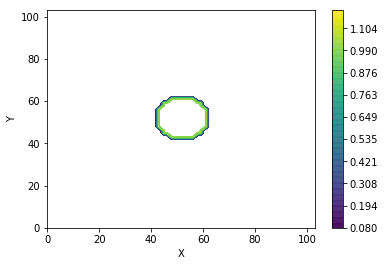

0.5
0.5
5


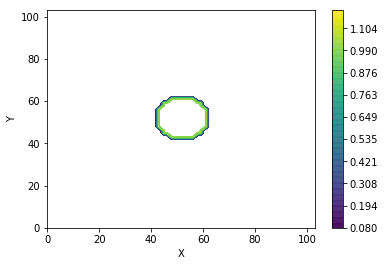

0.5
0.5
6


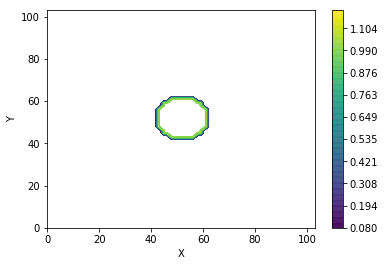

0.5
0.5
7


In [ ]:
main()

In [ ]:
# Homework
# Change the 2-D Godunov's method to second-order accurate in time, using midpoint quantities Wm and Um (follow 1-D example)
# Then run the blast wave solution again and compare the results with the first-order in time results
# to demonstrate that second-order in time is more accurate. 
